In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

In [2]:
# Read excel file
excel_name = 'thickness_data.xlsx'
sheet_name = 'Sheet1'

try:
    ex = pd.read_excel(excel_name, sheet_name=sheet_name)
except Exception as e:
    raise Exception('Error reading excel file: ' + str(e))
else:
    print('Successfully read excel file')

ex = ex.dropna(axis=0, how='any') # Drop rows with NaN values
if ex.shape[1] != 2:
    raise Exception('Excel file must have 2 columns')

distances = ex[ex.keys()[0]].values
thickness_factors = ex[ex.keys()[1]].values
if len(distances) != len(thickness_factors):
    raise Exception('Excel file must have the same number of rows for both columns')

print('First 5 rows of the data:')
print(ex.head().to_string(index=False, justify='center'))

Successfully read excel file
First 5 rows of the data:
 Distance from centre  Percentage of Average
           0                  0.985         
          10                  1.027         
          20                  1.034         
          30                  1.044         
          40                  1.065         


Equation: 0.394 / (1 + exp(-0.088 * (x - 42.702))) + -35.862 / (1 + exp(-0.013 * (x - 430.741))) + 1.172
Root Mean Square Error (RMSE): 0.043


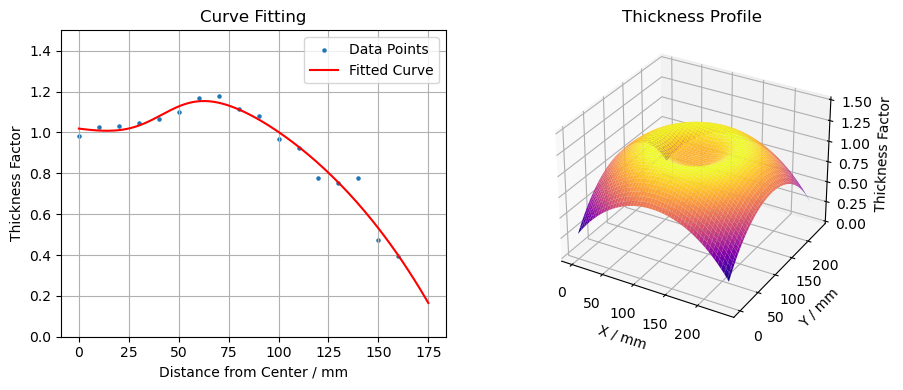

In [3]:
# Constants
PLATE_X = 237.62
PLATE_Y = 237.62
CENTER_X = PLATE_X / 2
CENTER_Y = PLATE_Y / 2

# Define the curve function
def curve_func(x, a1, b1, c1, a2, b2, c2, d):
    return c1 / (1 + np.exp(-a1 * (x - b1))) + c2 / (1 + np.exp(-a2 * (x - b2))) + d

initial_guesses = [0.1, 50, 0.25, 0.08, 100, -0.55, 1]

# Perform the curve fitting
popt, pcov = curve_fit(curve_func, distances, thickness_factors, p0=initial_guesses, maxfev=5000)
print(f'Equation: {popt[2]:.3f} / (1 + exp(-{popt[0]:.3f} * (x - {popt[1]:.3f}))) + {popt[5]:.3f} / (1 + exp(-{popt[3]:.3f} * (x - {popt[4]:.3f}))) + {popt[6]:.3f}')

# Generate x values for the curve
x_curve = np.arange(0, 176, 1)

# Generate y values using the fitted curve parameters
y_logistic = curve_func(x_curve, *popt)

# Fit with cubic spline to fix boundary conditions
cs = CubicSpline(x_curve, y_logistic, bc_type=((1, 0.), (2, 0.)))

# Generate y values using the fitted curve parameters
y_spline = cs(x_curve)

# Calculate the predicted values using the fitted curve
y_predicted = cs(distances)

# Calculate the root mean square error (RMSE)
rmse = np.sqrt(np.mean((thickness_factors - y_predicted) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse:.3f}")

# Make figure object
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], projection='3d')

# Plot the original data points and the fitted curve
ax1.scatter(distances, thickness_factors, s=5, label='Data Points')
# plt.plot(x_curve, y_logistic, 'g-', label='Logistic Curve')
ax1.plot(x_curve, y_spline, 'r-', label='Fitted Curve')
ax1.set_xlabel('Distance from Center / mm')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0, 1.5)
ax1.set_title('Curve Fitting')
ax1.grid()
ax1.legend()

# Plot profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)
zz_ = cs(np.sqrt((xx_ - CENTER_X) ** 2 + (yy_ - CENTER_Y) ** 2))

ax2.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')
ax2.set_xlabel('X / mm')
ax2.set_ylabel('Y / mm')
ax2.set_zlabel('Thickness Factor')
ax2.set_zlim(0, 1.5)
ax2.set_title('Thickness Profile')

plt.tight_layout()